In [ ]:
import os
import sys
import cv2
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

# from utils import to_var
# from train import train_model
# from data_utils import create_validation_data
# from vis_utils import imshow

use_gpu = torch.cuda.is_available()


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)
  
def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)

In [ ]:
def get_model(model_name, num_classes, pretrained=True):
    return models.__dict__[model_name](pretrained)


def read_annotations(path):
    """ Read Bounding Boxes from a json file.
    """
    anno_classes = [f.split('_')[0] for f in os.listdir(path)]
    bb_json = {}
    
    for c in anno_classes:
        j = json.load(open(f'{path}/{c}_labels.json', 'r'))
        for l in j:
#             print(l)
            if 'annotations' in l and len(l['annotations']) > 0:
                fname = l['filename'].split('/')[-1]
                bb_json[fname] = sorted(
                    l['annotations'], key=lambda x: x['height'] * x['width'])[-1]
    return bb_json


def bbox_to_r1c1r2c2(bbox):
    """ Convert BB from [h, w, x, y] to [r1, c1, r2, c2] format.
    """
    
    # extract h, w, x, y and convert to list
    bb = []
    bb.append(bbox['height'])
    bb.append(bbox['width'])
    bb.append(max(bbox['x'], 0))
    bb.append(max(bbox['y'], 0))
    
    # convert to float
    bb = [float(x) for x in bb]
    
    # convert to [r1, c1, r2, c2] format
    r1 = bb[3]
    c1 = bb[2]
    r2 = r1 + bb[0]
    c2 = c1 + bb[1]
    
    return [r1, c1, r2, c2]


def plot_bbox(img, bbox, w, h, color='red'):
    """ Plot bounding box on the image tensor. 
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)
    
    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # scale
    hs, ws = img.shape[:2]
    h_scale = h / hs
    w_scale = w / ws
    
    bb = np.array(bbox, dtype=np.float32)
    bx, by = bb[1], bb[0]
    bw = bb[3] - bb[1]
    bh = bb[2] - bb[0]
    
    bx *= w * w_scale
    by *= h * h_scale
    bw *= w * w_scale
    bh *= h * h_scale
    
    # scale image
    img = cv2.resize(img, (w, h))
    
    # create BB rectangle
    rect = plt.Rectangle((bx, by), bw, bh, color=color, fill=False, lw=3)
    
    # plot
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect)
    plt.show()

In [ ]:
DATA_DIR = "/content/gdrive/My Drive/data_sets/fish/"

data_dir = f'{DATA_DIR}data'
anno_dir = f'{DATA_DIR}annotations'

sz = 299  # image size
bs = 32   # batch size
model_name = 'resnet34'
num_classes = 8

In [ ]:
bb_json = read_annotations(anno_dir)

In [ ]:
files = glob(f'{DATA_DIR}data/ALB/*.*')
files[:5]

['/content/gdrive/My Drive/data_sets/fish/data/ALB/img_05000.jpg',
 '/content/gdrive/My Drive/data_sets/fish/data/ALB/img_01570.jpg',
 '/content/gdrive/My Drive/data_sets/fish/data/ALB/img_03714.jpg',
 '/content/gdrive/My Drive/data_sets/fish/data/ALB/img_00270.jpg',
 '/content/gdrive/My Drive/data_sets/fish/data/ALB/img_07876.jpg']

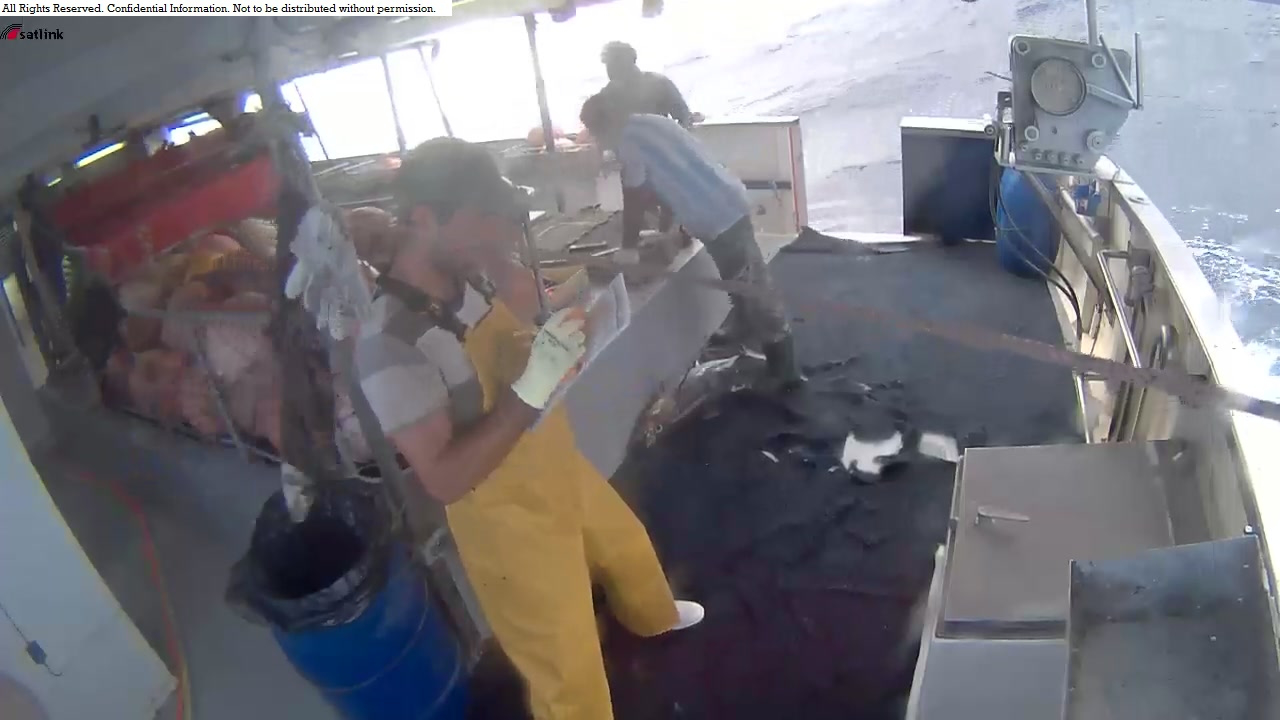

In [ ]:
Image.open(files[2])

# **fish data sets**

In [ ]:
class FishDataset(Dataset):
    def __init__(self, ds, bboxes, sz=299 , transforms = None):
        """ Prepare fish dataset
        
        Inputs:
            root: the directory which contains all required data such as images, labels, etc.
            ds: torchvision ImageFolder dataset.
            bboxes: a dictionary containing the coordinates of the bounding box in each images
            transforms: required transformations on each image
        """
        self.imgs = ds.imgs
        self.classes = ds.classes
        self.bboxes = bboxes
        self.sz = sz
        self.tfms = transforms

    
    def __getitem__(self, index):
        img, lbl = self.imgs[index]
        
        # get bounding box
        img_name = os.path.basename(img)
        if img_name in self.bboxes.keys():
            bbox = self.bboxes[img_name]
        else:
            bbox = {'class': 'rect', 'height': 0., 'width': 0., 'x': 0., 'y': 0.}
            
        # convert [h, w, x, y] to [r1, c1, r2, c2] format        
        bbox = bbox_to_r1c1r2c2(bbox)
        
        # read image and perform transformations
        image = Image.open(img).convert('RGB')
        w, h = image.size
        
        w_scale = sz / w
        h_scale = sz / h
        
        # transformations
        image = self.tfms(image)
        
        # normalize and scale bounding box
        bbox[0] = (bbox[0] / h) * h_scale
        bbox[1] = (bbox[1] / w) * w_scale
        bbox[2] = (bbox[2] / h) * h_scale
        bbox[3] = (bbox[3] / w) * w_scale
        
        # return image tensor, label tensor and bounding box tensor
        return image, lbl, torch.Tensor(bbox), (w, h)
    
    def __len__(self):
        return len(self.imgs)
      
      
class myds(Dataset):
    def __init__(self,ds,x):
        self.ds=ds
        self.x=x
        self.dataset_size=len(self.x)
        self.classes = ds.classes
        self.imgs = [ds.imgs[i] for i in x]

    def __getitem__(self,index):
        return self.ds[self.x[index % self.dataset_size]]

    def __len__(self):
        return self.dataset_size
      
    def __classes__(self):
      return self.classes
    
    def __imgs__(self):
      return self.imgs 

In [ ]:
#transforms

tmfs = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# training test  data
data_ds = datasets.ImageFolder(data_dir)

indexes = [i for i in range(len(data_ds))]
train_indexes , test_indexes = train_test_split(indexes , test_size = 0.2)

tra_ds = myds(data_ds , train_indexes)
tes_ds = myds(data_ds , test_indexes)


train_ds = FishDataset(tra_ds, bb_json, sz=sz , transforms=tmfs)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True , num_workers=64)

test_ds = FishDataset(tes_ds , bb_json, sz=sz , transforms=tmfs)
test_dl = DataLoader(test_ds , batch_size = 1 , shuffle=True , num_workers=64)

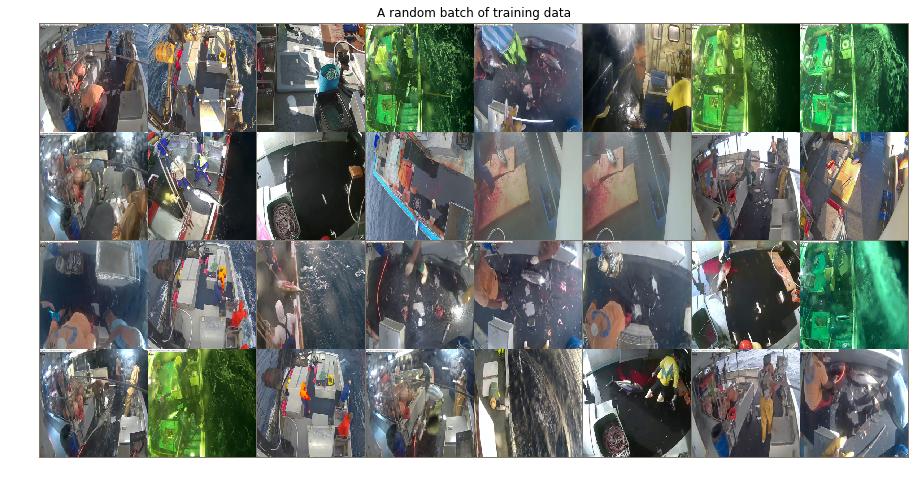

In [ ]:
dataiter = iter(train_dl)
imgs, lbls, bbs, sizes = next(dataiter)
img = torchvision.utils.make_grid(imgs, nrow=8)
plt.figure(figsize=(16, 8))
imshow(img, title='A random batch of training data')

torch.Size([3, 299, 299])
0 : ALB
[0.22436535 0.0673407  0.30222994 0.09471497]


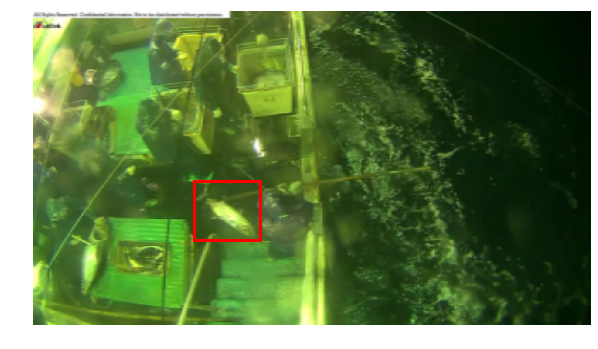

In [ ]:
# get one specific data from training data
img, lbl, bb, (w, h) = train_ds[10]

# print size, label, and bounding box
print(img.size())
print(lbl, ':', train_ds.classes[lbl])
print(bb.numpy())

# plot image and bounding box
plot_bbox(img, bb, w, h)

In [ ]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=8):
        super().__init__()
        self.num_classes = num_classes
        
        # create cnn model
        model = get_model(model_name, num_classes)
        
        # remove fc layers and add a new fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes + 4) # classifier + localizer
        self.model = model
    
    def forward(self, x):
        x = self.model(x)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # bb corners coordinates
        return scores, torch.sigmoid(coords)     # sigmoid output is in [0, 1]

In [ ]:
class LocalizationLoss(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(size_average=False)
        self.mse_loss = nn.MSELoss(size_average=False)
        
    def forward(self, scores, locs, labels, bboxes):
        # Cross Entropy (for classification)
        loss_cls = self.ce_loss(scores, labels)
        
        # Sum of Squared errors (for corner points)
        loss_r1 = self.mse_loss(locs[:, 0], bboxes[:, 0]) / 2.0
        loss_c1 = self.mse_loss(locs[:, 1], bboxes[:, 1]) / 2.0
        loss_r2 = self.mse_loss(locs[:, 2], bboxes[:, 2]) / 2.0
        loss_c2 = self.mse_loss(locs[:, 3], bboxes[:, 3]) / 2.0
        
        return loss_cls, loss_r1 + loss_c1 + loss_r2 + loss_c2

In [ ]:
model = ClassifierLocalizer(model_name)
if use_gpu: model = model.cuda()
    
criterion = LocalizationLoss()
if use_gpu: criterion = criterion.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
def train_one_epoch(model, dataloder, criterion, optimizer, scheduler):
    if scheduler is not None:
        scheduler.step()
    
    model.train(True)
    
    steps = len(dataloder.dataset) // dataloder.batch_size
    
    running_loss = 0.0
    running_cls_loss = 0.0
    running_loc_loss = 0.0
    running_corrects = 0
    
    for i, (inputs, labels, bboxes, _) in enumerate(dataloder):
        inputs, labels, bboxes = to_var(inputs), to_var(labels), to_var(bboxes)
        
        optimizer.zero_grad()
        
        # forward
        scores, locs = model(inputs)
        _, preds = torch.max(scores.data, 1)
        cls_loss, loc_loss = criterion(scores, locs, labels, bboxes)        
        loss = cls_loss + 10.0 * loc_loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # statistics
        running_cls_loss = (running_cls_loss * i + cls_loss.data.item()) / (i + 1)
        running_loc_loss = (running_loc_loss * i + loc_loss.data.item()) / (i + 1)
        running_loss  = (running_loss * i + loss.data.item()) / (i + 1)
        running_corrects += torch.sum(preds == labels.data)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r  Step %d/%d | Loss: %.5f (%.5f + %.5f)" % 
                         (i, steps, running_loss, running_cls_loss, running_loc_loss))
        
    epoch_loss = running_loss
    epoch_acc = running_corrects.data.item() / len(dataloder.dataset)
    
    sys.stdout.flush()
    print('\r{} Loss: {:.5f} ({:.5f} + {:.5f}), Acc: {:.5f}'.format(
        '  train', epoch_loss, running_cls_loss, running_loc_loss, epoch_acc))
    
    return model

    
def validate_model(model, dataloder, criterion):
    model.train(False)
    
    steps = len(dataloder.dataset) // dataloder.batch_size
    
    running_loss = 0.0
    running_cls_loss = 0.0
    running_loc_loss = 0.0
    running_corrects = 0
    
    for i, (inputs, labels, bboxes, _) in enumerate(dataloder):
        inputs, labels, bboxes = to_var(inputs, True), to_var(labels, True), to_var(bboxes, True)
              
        # forward
        scores, locs = model(inputs)
        _, preds = torch.max(scores.data, 1)
        cls_loss, loc_loss = criterion(scores, locs, labels, bboxes)
        loss = cls_loss + 10.0 * loc_loss
            
        # statistics
        running_cls_loss = (running_cls_loss * i + cls_loss.data.item()) / (i + 1)
        running_loc_loss = (running_loc_loss * i + loc_loss.data.item()) / (i + 1)
        running_loss  = (running_loss * i + loss.data.item()) / (i + 1)
        running_corrects += torch.sum(preds == labels.data)
        
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r  Step %d/%d | Loss: %.5f (%.5f + %.5f)" % 
                         (i, steps, running_loss, running_cls_loss, running_loc_loss))
        
    epoch_loss = running_loss
    epoch_acc = running_corrects.data.item() / len(dataloder.dataset)
    
    print('running corrects ; ' , running_corrects)
    print('len data loader : ' , len(dataloder.dataset))
    print('epoch acc : ' , epoch_acc )
    
    sys.stdout.flush()
    print('\r{} Loss: {:.5f} ({:.5f} + {:.5f}), Acc: {:.5f}'.format(
        '  valid', epoch_loss, running_cls_loss, running_loc_loss, epoch_acc))
    
    return epoch_acc


def train_model(model, train_dl, valid_dl, criterion, optimizer,
                scheduler=None, num_epochs=10 ,model_name = 'restnet34' , save_model = False):

    if not os.path.exists('models'):
        os.mkdir('models')
    
    since = time.time()
    
    acc_history = []
    
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        ## train and validate
        model = train_one_epoch(model, train_dl, criterion, optimizer, scheduler)
        val_acc = validate_model(model, valid_dl, criterion)
        
        acc_history.append(val_acc)
        
        # deep copy the model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()

        print()
    #save model 
    if save_model :
      torch.save(model.state_dict(), "/content/gdrive/My Drive/data_sets/fish/models/{}-epoch-{}-acc-{:.5f}.pth".format(model_name , epoch, best_acc))
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model , acc_history

In [ ]:
model , acc_history = train_model(model, train_dl, test_dl, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------
  train Loss: 27.71484 (20.54019 + 0.71747), Acc: 0.80834


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


  Step 755/756 | Loss: 0.25364 (0.21661 + 0.00370)running corrects ;  tensor(707, device='cuda:0')
len data loader :  756
epoch acc :  0.9351851851851852
  valid Loss: 0.25364 (0.21661 + 0.00370), Acc: 0.93519

Epoch 2/20
----------
  train Loss: 3.26434 (2.31004 + 0.09543), Acc: 0.98676
  Step 755/756 | Loss: 0.16982 (0.14033 + 0.00295)running corrects ;  tensor(732, device='cuda:0')
len data loader :  756
epoch acc :  0.9682539682539683
  valid Loss: 0.16982 (0.14033 + 0.00295), Acc: 0.96825

Epoch 3/20
----------
  train Loss: 1.16605 (0.48089 + 0.06852), Acc: 0.99901
  Step 755/756 | Loss: 0.14517 (0.11668 + 0.00285)running corrects ;  tensor(735, device='cuda:0')
len data loader :  756
epoch acc :  0.9722222222222222
  valid Loss: 0.14517 (0.11668 + 0.00285), Acc: 0.97222

Epoch 4/20
----------
  train Loss: 0.79297 (0.26623 + 0.05267), Acc: 0.99901
  Step 755/756 | Loss: 0.16910 (0.14114 + 0.00280)running corrects ;  tensor(728, device='cuda:0')
len data loader :  756
epoch acc :

In [ ]:
os.chdir('/content/gdrive/My Drive/data_sets/fish/models')
!ls -a

In [ ]:
len(acc_history)

20

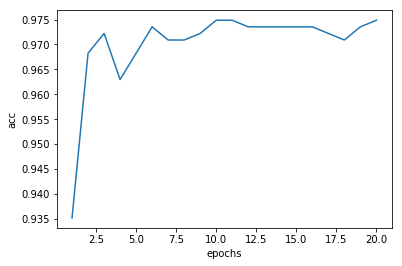

In [ ]:
#print acc_history 
epochs = [(i+1) for i in range(len(acc_history))]
plt.plot(epochs , acc_history ,label = 'accuresy per epoch')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()
    
 

In [ ]:
def plot_bboxs(img, bbox1 , bbox2, w, h, color2='red' , color1 = 'green'):
    """ Plot bounding box on the image tensor. 
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)
    
    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # scale
    hs, ws = img.shape[:2]
    h_scale = h / hs
    w_scale = w / ws
    
    bb1 = np.array(bbox1, dtype=np.float32)
    bx1, by1 = bb1[1], bb1[0]
    bw1 = bb1[3] - bb1[1]
    bh1 = bb1[2] - bb1[0]
    
    bx1 *= w * w_scale
    by1 *= h * h_scale
    bw1 *= w * w_scale
    bh1 *= h * h_scale
    
    
    bb2 = np.array(bbox2, dtype=np.float32)
    bx2, by2 = bb2[1], bb2[0]
    bw2 = bb2[3] - bb2[1]
    bh2 = bb2[2] - bb2[0]
    
    bx2 *= w * w_scale
    by2 *= h * h_scale
    bw2 *= w * w_scale
    bh2 *= h * h_scale
    
    # scale image
    img = cv2.resize(img, (w, h))
    
    # create BB rectangle
    rect1 = plt.Rectangle((bx1, by1), bw1, bh1, color=color1, fill=False, lw=4)
    rect2 = plt.Rectangle((bx2, by2), bw2, bh2, color=color2, fill=False, lw=3)
    
    # plot
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect1)
    plt.gca().add_patch(rect2)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


class      : OTHER
predicted  : OTHER



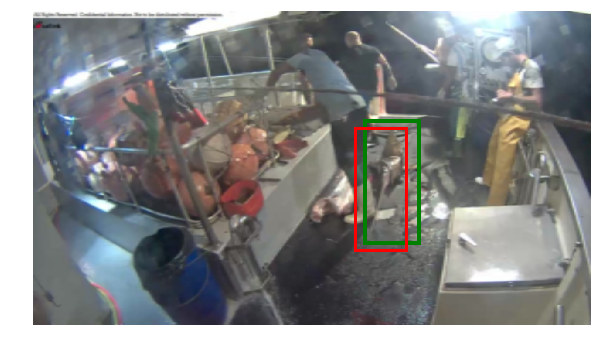

class      : NoF
predicted  : NoF



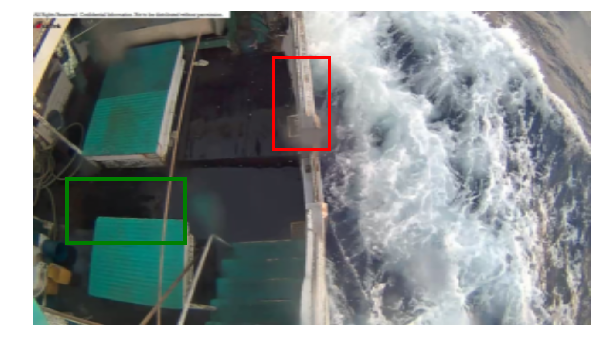

class      : OTHER
predicted  : OTHER



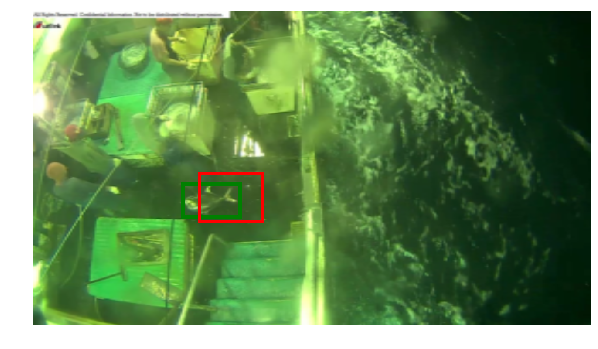

class      : ALB
predicted  : ALB



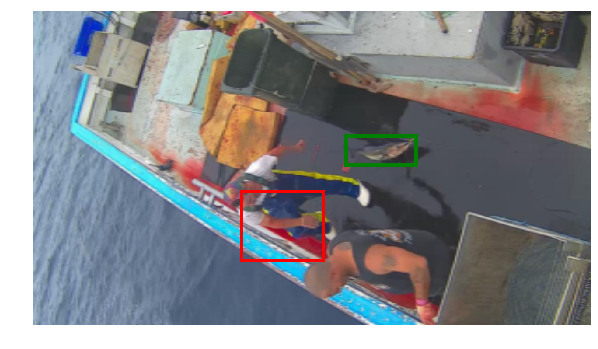

class      : ALB
predicted  : ALB



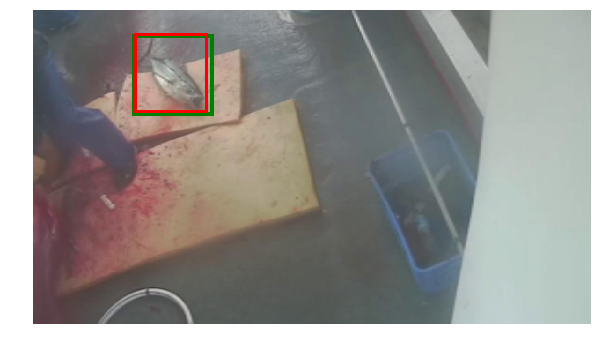

class      : ALB
predicted  : ALB



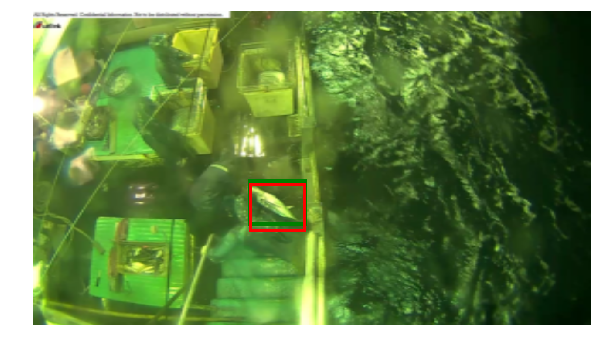

class      : ALB
predicted  : ALB



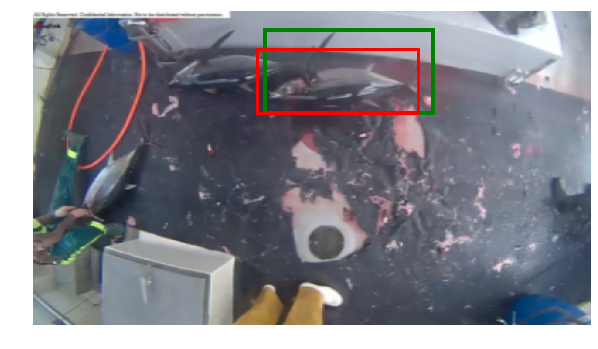

class      : OTHER
predicted  : OTHER



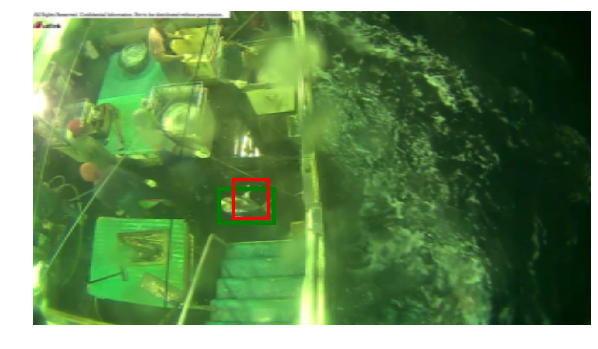

class      : YFT
predicted  : YFT



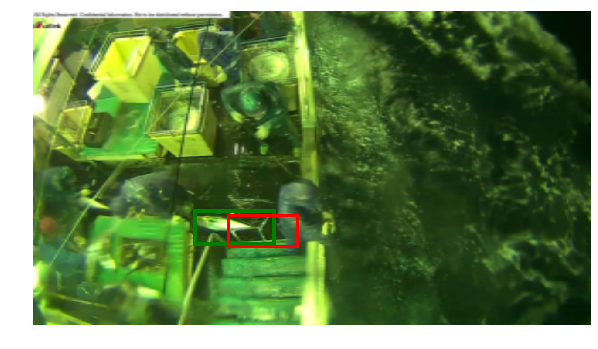

class      : ALB
predicted  : ALB



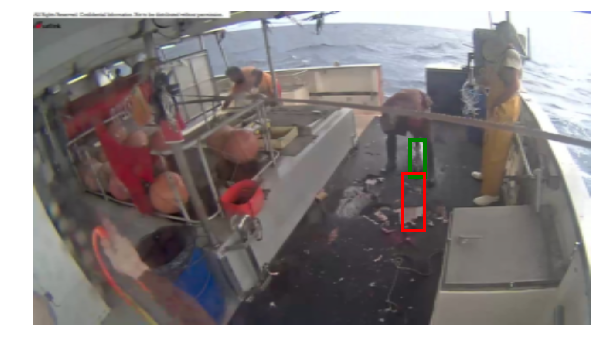

In [ ]:
for i in range(10):
  test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)
  imgs, lbls, bbs, sizes = next(iter(test_dl))
  scores, locs = model(to_var(imgs, volatile=True))

  scores = scores.data.cpu().numpy()
  locs = locs.data.cpu().numpy()

  pred_lbl = np.argmax(scores, axis=1)[0]
  pred_bb = locs[0].tolist()

  print('class ', '    :' , test_ds.classes[lbls])
  print('predicted ', ':', test_ds.classes[pred_lbl])

  w, h = sizes[0].numpy(), sizes[1].numpy()
  print()
  # plot_bbox(imgs[0], pred_bb, w, h)
  # plot_bbox(imgs[0], bbs.numpy()[0], w , h)
  plot_bboxs(imgs[0] ,bbs.numpy()[0] , pred_bb , w , h)